In [1]:
import gwsurrogate
import numpy as np
import matplotlib.pyplot as plt
import bilby
from gwpy.timeseries import TimeSeries
from scipy.special import expit
import pandas as pd

lal.G_SI != G
lal.MSUN_SI != Msun
setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


In [2]:
sur=gwsurrogate.LoadSurrogate('NRSur7dq4')

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/Users/zohaggard/anaconda2/envs/igw

Loaded NRSur7dq4 model


In [3]:
def sigmoid(time, x0, L, k):
    
    """ generate a sigmoid to be mult. to damped sinusoid.
        x is time, x0 is the midpoint of the sigmoid, L is the amplitude, and k is the growth 
    """
    
    sig = []
    
    for item in time:
        value=L/(1+np.exp(-k*(item-x0)))
        sig.append(value)
        
    return sig

In [4]:
def create_bru_values(m_odd, em, M, a, n_ref):
    
    """ 
    m_odd is odd integer, n_ref is the refractive index, which is 1/g_s (string coupling, (GR == 0)), em is 2,
    M is total mass, a is dimensionless spin, and amplitude_qnm is 
    the amplitude of the mode of interest 
    
    returns amplitude (quantum), omega_real, tau, and tp
    
    """
    
    g_s = 1/n_ref
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    
    conversion_w = (c**3)/(G * M * Msun)
    R_con = (2 * G * M * Msun) / (c**2)
    
    r_s = (R_con + np.sqrt((R_con**2) - 4*(a**2)))/2 #units m
    omega_real = (m_odd * np.pi /(2 * r_s * n_ref)) * c   #units 1/m --> 1/s
    omega_im = - (1/r_s) * (1/(n_ref**2)) * c
    
    tau = 1/omega_im
    tp = 1/omega_real 
    
    print("Quantum freq is {}".format(omega_real/(2*np.pi)))
    print("Quantum tau is {}".format(tau))
    print("t_s is {}".format(tp))
    
    return {'omega_real_Q': omega_real, 'omega_img_Q': omega_im,
            'tau_Q': tau, 'tp_Q': tp, 'freq_Q': (omega_real/(2*np.pi))}

In [5]:
def damped_sine(time, amplitude, tau, tp, freq, phase):
    
    """
    returns damped complex sine as h (type=array) 
    assumes that tau is negative number
    starts a time tp: anytime before is 0

    """
    
    
    h_damped = np.zeros(len(time), dtype=np.complex128)
    tidx = time >= tp
    
    damp_arg = - (time[tidx])/tau
    sin_arg = (2 * np.pi * freq * (time[tidx])) - phase
    h_damped[tidx] = amplitude*np.exp(damp_arg) * np.exp((1j*sin_arg)) 
   
    return h_damped

In [6]:
def Quantummodes_keys(time, tau, freq, tp, amplitude, phase):
    
    """ 
    model that has NR SUR (for given parameters) and associated quantum mode 
    chiA and chiB take [x,y,z] as input
    assumes dt = 1/4096
    highest l index is ellMax, assumed to be 4
    f_ref=30, and f_low=0
    
    note: NRSUR peak of waveform packet is at t=0
    
          spin=0 for now (need to change em otherwise)
    
    """
    #generate damped 
    bru_sin = damped_sine(time=time, amplitude=amplitude, tau=tau, tp=tp, freq=freq, 
                          phase=phase)
    
    sig = sigmoid(time=time, x0=tp*2, L=amplitude, k=4096)
    
    dif = len(bru_sin) - len(h)
    
    h_new = np.pad(h, (0, dif), 'constant')
    
    h_total = h_new + (bru_sin*sig/amplitude)
    
    return {'plus': h_total.real, 'cross': h_total.imag}
    

In [7]:
def Quantummodes(time, n_ref, amplitude, phase, M):
    
    """ 
    model that has NR SUR (for given parameters) and associated quantum mode 
    chiA and chiB take [x,y,x] as input
    assumes dt = 1/4096
    highest l index is ellMax, assumed to be 4
    f_ref=30, and f_low=0
    
    note: NRSUR peak of waveform packet is at t=0
    
          spin=0 for now (need to change em otherwise)
    
    """
    
    #h_new
    print(time)
    
    bru_values = create_bru_values(m_odd=1, em=0, M=M, a=0, n_ref=n_ref)
    
    bru_sin = damped_sine(time=time, amplitude=amplitude, 
                       tau=-1*bru_values['tau_Q'], tp=bru_values['tp_Q'], 
                       freq=bru_values['freq_Q'], phase=phase)
    
    sig = sigmoid(time=time, x0=bru_values['tp_Q']*2, L=amplitude, k=4096)
    
    dif = len(bru_sin) - len(h)
    
    h_new = np.pad(h, (0, dif), 'constant')
    
    h_total = h_new + (bru_sin*sig/amplitude)
    
    plt.plot(time, h_new.real, label='NRsurdq4', linestyle='--', color='blue')
    plt.plot(time, sig*bru_sin.real/amplitude, label='quantum mode', linestyle='-.', color='green')
    plt.plot(time, h_total, label='injected waveform', linestyle='-', color='orange')
    plt.legend()
    plt.xlim(-0.01,0.08)
    plt.xlabel('Time (seconds)')
    plt.ylabel('h+')
    plt.savefig('/Users/zohaggard/Desktop/plts_for_bilby/amp{}_nref{}_M{}'.format(amplitude, n_ref, M))
   
    
    return {'plus': h_total.real, 'cross': h_total.imag}
    

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


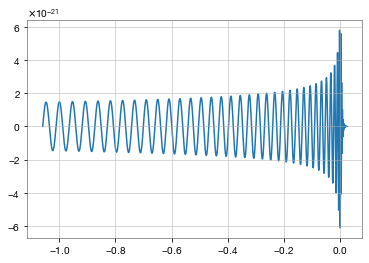

In [37]:
q = 1
chiA = [0,0,0]
chiB = [0,0,0]
M = 50
dist_mpc = 100
ellMax = 4     
inclination = 0
f_low=0
f_ref = 30
dt=1/4096

t, h, dyn = sur(q, chiA, chiB, dt=dt, f_low=f_low, ellMax=ellMax, M=M, dist_mpc=dist_mpc,
               inclination=inclination, units='mks', f_ref=f_ref)
plt.plot(t, h)

In [42]:
n_ref=11
amplitudelist=[6e-23, 8e-23, 1e-22]
duration=3

In [43]:
df=pd.DataFrame(columns={'amp','mass','nref','L1_SNR', 'log_bayes_factor'})

for amplitude in amplitudelist:
    injection_parameters = dict(n_ref=n_ref, amplitude=amplitude, phase=0,
                            ra=0, dec=0, psi=0, geocent_time=0, M=M)
    
    injection_waveform = bilby.gw.waveform_generator.WaveformGenerator(
                        time_domain_source_model=Quantummodes,
                        duration=duration, sampling_frequency=4096, 
                        start_time = injection_parameters['geocent_time']+t[0])
        
    ifos = bilby.gw.detector.InterferometerList(['H1','L1'])
    ifos.set_strain_data_from_power_spectral_densities(
                        duration=duration, sampling_frequency=4096, 
                        start_time = injection_parameters['geocent_time']+t[0])
    ifos.inject_signal(waveform_generator=injection_waveform,
                  parameters=injection_parameters)
    
    prior = {}
    prior['amplitude'] = bilby.core.prior.DeltaFunction(amplitude, r'$h_0$')
    prior['tp'] = bilby.core.prior.DeltaFunction(0.0027527, r'$t_{s}$')
    prior['tau'] = bilby.core.prior.LogUniform(1e-3, 1e-1, r'$\tau$', unit='$s$')
    prior['freq'] = bilby.core.prior.Uniform(30, 100, r'frequency', unit='Hz')
    prior['phase'] = bilby.core.prior.DeltaFunction(0)
    prior['ra'] = bilby.core.prior.DeltaFunction(0)
    prior['dec'] = bilby.core.prior.DeltaFunction(0)
    prior['psi'] = bilby.core.prior.DeltaFunction(0)
    prior['geocent_time'] = bilby.core.prior.DeltaFunction(0)
    
    search_waveform = bilby.gw.WaveformGenerator(
                        duration=duration, sampling_frequency=4096, 
                        time_domain_source_model=Quantummodes_keys, 
                        start_time = injection_parameters['geocent_time']+t[0])
    
    likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
                        interferometers=ifos, waveform_generator=search_waveform)
    
    result = bilby.run_sampler(
            likelihood=likelihood, priors=prior, sampler='dynesty', npoints=100, walks=5, 
            nact=3, outdir='/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurquantum_ampvary',
            label='Mass{}_nref{}_Amp{}'.format(M, n_ref, amplitude),
            resume=False, injection_parameters=dict(freq=57.8176,
                                                    tau=0.04756))
    result.plot_corner()
    df = df.append({'amp':amplitude,'mass':M,'nref':n_ref,'L1_SNR':ifos.meta_data['L1']['optimal_SNR'],
                         'log_bayes_factor': result.log_bayes_factor}, ignore_index=True)
    df.to_csv('/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurquantum_ampvary/nref{}'.format(n_ref))

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
21:21 bilby INFO    : Injected signal in H1:
21:21 bilby INFO    :   optimal SNR = 232.51
21:21 bilby INFO    :   matched filter SNR = 233.97-0.65j
21:21 bilby INFO    :   n_ref = 11
21:21 bilby INFO    :   amplitude = 6e-23
21:21 bilby INFO    :   phase = 0
21:21 bilby INFO    :   ra = 0
21:21 bilby INFO    :   dec = 0
21:

[-1.05898057 -1.05873643 -1.05849229 ...  1.94028701  1.94053115
  1.94077529]
Quantum freq is 46.254125097056566
Quantum tau is -0.05945415666666667
t_s is 0.003440881062130896


21:21 bilby INFO    :   dec = 0
21:21 bilby INFO    :   psi = 0
21:21 bilby INFO    :   geocent_time = 0
21:21 bilby INFO    :   M = 50
21:21 bilby INFO    : Running for label 'Mass50_nref11_Amp6e-23', output will be saved to '/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurquantum_ampvary'
21:21 bilby INFO    : Using LAL version Branch: None;Tag: lal-v6.22.0;Id: 38829b72bfb5f26391b9866d286dd77db7942dd1;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
21:21 bilby INFO    : Search parameters:
21:21 bilby INFO    :   tau = LogUniform(minimum=0.001, maximum=0.1, name='$\\tau$', latex_label='$\\tau$', unit='$s$', boundary=None)
21:21 bilby INFO    :   freq = Uniform(minimum=30, maximum=100, name='frequency', latex_label='frequency', unit='Hz', boundary=None)
21:21 bilby INFO    :   amplitude = 6e-23
21:21 bilby INFO    :   tp = 0.0027527
21:21 bilby INFO    :   phase = 0
21:21 bilby INFO    :   ra = 0
21:21 bilby INFO    :   de

0it [00:00, ?it/s]

21:21 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 5, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1370f4050>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 3}
21:21 bilby INFO    : Checkpoint every n_check_point = 20000
21:21 bilby INFO    : Using dynesty version 1.0.1
21:21 bilby INFO    : Using the bilby-implemented rwalk sample metho

388it [02:13,  1.45s/it, bound:0 nc:53 ncall:3914 eff:9.9% logz-ratio=64919.38+/-0.09 dlogz:1.803>0.10]  

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


393it [02:16,  1.51it/s, bound:1 nc:11 ncall:3978 eff:9.9% logz-ratio=64919.39+/-0.09 dlogz:1.753>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


397it [02:18,  1.68it/s, bound:2 nc:13 ncall:4040 eff:9.8% logz-ratio=64919.40+/-0.09 dlogz:1.713>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


402it [02:21,  2.01it/s, bound:3 nc:12 ncall:4104 eff:9.8% logz-ratio=64919.41+/-0.10 dlogz:1.664>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


407it [02:23,  2.17it/s, bound:4 nc:9 ncall:4164 eff:9.8% logz-ratio=64919.42+/-0.10 dlogz:1.615>0.10] 

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


412it [02:26,  1.94it/s, bound:5 nc:17 ncall:4232 eff:9.7% logz-ratio=64919.43+/-0.10 dlogz:1.593>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


417it [02:28,  1.74it/s, bound:6 nc:14 ncall:4297 eff:9.7% logz-ratio=64919.44+/-0.10 dlogz:1.544>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


422it [02:31,  1.87it/s, bound:7 nc:14 ncall:4364 eff:9.7% logz-ratio=64919.46+/-0.10 dlogz:1.496>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


427it [02:34,  1.90it/s, bound:8 nc:17 ncall:4430 eff:9.6% logz-ratio=64919.47+/-0.10 dlogz:1.448>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


432it [02:36,  1.77it/s, bound:9 nc:17 ncall:4500 eff:9.6% logz-ratio=64919.48+/-0.10 dlogz:1.400>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


438it [02:39,  2.50it/s, bound:10 nc:9 ncall:4562 eff:9.6% logz-ratio=64919.50+/-0.11 dlogz:1.408>0.10] 

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


443it [02:41,  2.05it/s, bound:11 nc:10 ncall:4631 eff:9.6% logz-ratio=64919.51+/-0.11 dlogz:1.362>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


449it [02:44,  2.43it/s, bound:12 nc:7 ncall:4697 eff:9.6% logz-ratio=64919.52+/-0.11 dlogz:1.306>0.10] 

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


454it [02:46,  2.25it/s, bound:13 nc:10 ncall:4761 eff:9.5% logz-ratio=64919.54+/-0.11 dlogz:1.261>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


460it [02:49,  2.30it/s, bound:14 nc:12 ncall:4831 eff:9.5% logz-ratio=64919.55+/-0.11 dlogz:1.207>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


465it [02:51,  2.18it/s, bound:15 nc:13 ncall:4893 eff:9.5% logz-ratio=64919.57+/-0.12 dlogz:1.163>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


470it [02:54,  1.98it/s, bound:16 nc:16 ncall:4957 eff:9.5% logz-ratio=64919.58+/-0.12 dlogz:1.120>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


476it [02:56,  2.09it/s, bound:17 nc:18 ncall:5025 eff:9.5% logz-ratio=64919.60+/-0.12 dlogz:1.069>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


481it [02:59,  2.07it/s, bound:18 nc:12 ncall:5089 eff:9.5% logz-ratio=64919.61+/-0.12 dlogz:1.028>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


486it [03:01,  2.17it/s, bound:19 nc:11 ncall:5151 eff:9.4% logz-ratio=64919.63+/-0.12 dlogz:1.009>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


491it [03:03,  2.14it/s, bound:20 nc:13 ncall:5215 eff:9.4% logz-ratio=64919.64+/-0.13 dlogz:0.970>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


495it [03:06,  1.84it/s, bound:21 nc:20 ncall:5275 eff:9.4% logz-ratio=64919.65+/-0.13 dlogz:0.938>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


499it [03:08,  1.79it/s, bound:22 nc:18 ncall:5335 eff:9.4% logz-ratio=64919.66+/-0.13 dlogz:0.908>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


505it [03:10,  2.29it/s, bound:23 nc:12 ncall:5396 eff:9.4% logz-ratio=64919.68+/-0.13 dlogz:0.871>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


511it [03:13,  2.26it/s, bound:24 nc:11 ncall:5464 eff:9.4% logz-ratio=64919.69+/-0.13 dlogz:0.827>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


517it [03:15,  2.05it/s, bound:25 nc:15 ncall:5535 eff:9.3% logz-ratio=64919.71+/-0.14 dlogz:0.785>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


522it [03:18,  1.99it/s, bound:26 nc:13 ncall:5606 eff:9.3% logz-ratio=64919.72+/-0.14 dlogz:0.752>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


527it [03:20,  2.04it/s, bound:27 nc:14 ncall:5670 eff:9.3% logz-ratio=64919.74+/-0.14 dlogz:0.719>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


533it [03:23,  2.33it/s, bound:28 nc:12 ncall:5740 eff:9.3% logz-ratio=64919.75+/-0.14 dlogz:0.682>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


538it [03:25,  1.89it/s, bound:29 nc:20 ncall:5806 eff:9.3% logz-ratio=64919.76+/-0.14 dlogz:0.651>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


542it [03:28,  1.74it/s, bound:30 nc:15 ncall:5871 eff:9.2% logz-ratio=64919.77+/-0.14 dlogz:0.628>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


548it [03:31,  1.79it/s, bound:31 nc:13 ncall:5943 eff:9.2% logz-ratio=64919.79+/-0.15 dlogz:0.597>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


553it [03:33,  2.10it/s, bound:32 nc:10 ncall:6003 eff:9.2% logz-ratio=64919.80+/-0.15 dlogz:0.570>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


559it [03:36,  2.26it/s, bound:33 nc:14 ncall:6073 eff:9.2% logz-ratio=64919.81+/-0.15 dlogz:0.538>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


564it [03:38,  2.08it/s, bound:34 nc:13 ncall:6135 eff:9.2% logz-ratio=64919.83+/-0.15 dlogz:0.513>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


569it [03:41,  2.16it/s, bound:35 nc:12 ncall:6195 eff:9.2% logz-ratio=64919.84+/-0.15 dlogz:0.497>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


573it [03:43,  1.88it/s, bound:36 nc:14 ncall:6255 eff:9.2% logz-ratio=64919.85+/-0.15 dlogz:0.478>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


578it [03:46,  1.65it/s, bound:37 nc:23 ncall:6337 eff:9.1% logz-ratio=64919.86+/-0.16 dlogz:0.455>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


584it [03:48,  2.35it/s, bound:38 nc:12 ncall:6406 eff:9.1% logz-ratio=64919.87+/-0.16 dlogz:0.429>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


589it [03:51,  2.08it/s, bound:39 nc:11 ncall:6474 eff:9.1% logz-ratio=64919.88+/-0.16 dlogz:0.409>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


595it [03:53,  2.21it/s, bound:40 nc:11 ncall:6542 eff:9.1% logz-ratio=64919.89+/-0.16 dlogz:0.386>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


601it [03:56,  2.30it/s, bound:41 nc:9 ncall:6609 eff:9.1% logz-ratio=64919.90+/-0.16 dlogz:0.363>0.10] 

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


606it [03:58,  2.12it/s, bound:42 nc:14 ncall:6674 eff:9.1% logz-ratio=64919.91+/-0.16 dlogz:0.346>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


611it [04:01,  1.91it/s, bound:43 nc:15 ncall:6745 eff:9.1% logz-ratio=64919.92+/-0.16 dlogz:0.329>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


616it [04:04,  2.04it/s, bound:44 nc:12 ncall:6815 eff:9.0% logz-ratio=64919.93+/-0.16 dlogz:0.313>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


621it [04:06,  1.79it/s, bound:45 nc:23 ncall:6888 eff:9.0% logz-ratio=64919.94+/-0.17 dlogz:0.298>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


626it [04:09,  2.03it/s, bound:46 nc:14 ncall:6952 eff:9.0% logz-ratio=64919.94+/-0.17 dlogz:0.283>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


631it [04:11,  2.12it/s, bound:47 nc:11 ncall:7019 eff:9.0% logz-ratio=64919.95+/-0.17 dlogz:0.269>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


636it [04:14,  2.03it/s, bound:48 nc:13 ncall:7084 eff:9.0% logz-ratio=64919.96+/-0.17 dlogz:0.256>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


641it [04:16,  1.99it/s, bound:49 nc:14 ncall:7152 eff:9.0% logz-ratio=64919.97+/-0.17 dlogz:0.243>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


647it [04:19,  2.38it/s, bound:50 nc:11 ncall:7220 eff:9.0% logz-ratio=64919.98+/-0.17 dlogz:0.229>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


652it [04:21,  1.94it/s, bound:51 nc:18 ncall:7286 eff:8.9% logz-ratio=64919.98+/-0.17 dlogz:0.218>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


657it [04:24,  2.15it/s, bound:52 nc:12 ncall:7350 eff:8.9% logz-ratio=64919.99+/-0.17 dlogz:0.207>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


662it [04:26,  1.97it/s, bound:53 nc:17 ncall:7421 eff:8.9% logz-ratio=64919.99+/-0.17 dlogz:0.197>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


667it [04:28,  2.13it/s, bound:54 nc:11 ncall:7488 eff:8.9% logz-ratio=64920.00+/-0.17 dlogz:0.187>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


673it [04:31,  2.43it/s, bound:55 nc:12 ncall:7557 eff:8.9% logz-ratio=64920.01+/-0.17 dlogz:0.176>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


678it [04:33,  2.26it/s, bound:56 nc:10 ncall:7625 eff:8.9% logz-ratio=64920.01+/-0.17 dlogz:0.167>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


684it [04:36,  2.33it/s, bound:57 nc:12 ncall:7694 eff:8.9% logz-ratio=64920.02+/-0.18 dlogz:0.157>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


689it [04:38,  2.14it/s, bound:58 nc:12 ncall:7758 eff:8.9% logz-ratio=64920.02+/-0.18 dlogz:0.149>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


694it [04:41,  2.25it/s, bound:59 nc:11 ncall:7820 eff:8.9% logz-ratio=64920.03+/-0.18 dlogz:0.142>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


699it [04:43,  1.79it/s, bound:60 nc:16 ncall:7891 eff:8.9% logz-ratio=64920.03+/-0.18 dlogz:0.135>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


705it [04:46,  2.16it/s, bound:61 nc:13 ncall:7963 eff:8.9% logz-ratio=64920.04+/-0.18 dlogz:0.127>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


710it [04:48,  2.32it/s, bound:62 nc:8 ncall:8025 eff:8.8% logz-ratio=64920.04+/-0.18 dlogz:0.121>0.10] 

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


715it [04:51,  2.07it/s, bound:63 nc:14 ncall:8092 eff:8.8% logz-ratio=64920.05+/-0.18 dlogz:0.115>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


721it [04:53,  2.30it/s, bound:64 nc:11 ncall:8160 eff:8.8% logz-ratio=64920.05+/-0.18 dlogz:0.109>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


727it [04:56,  2.48it/s, bound:65 nc:10 ncall:8229 eff:8.8% logz-ratio=64920.06+/-0.18 dlogz:0.103>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


729it [04:57,  2.60it/s, bound:66 nc:9 ncall:8248 eff:8.8% logz-ratio=64920.06+/-0.18 dlogz:0.101>0.10] 

21:26 bilby INFO    : Writing checkpoint file /Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurquantum_ampvary/Mass50_nref11_Amp6e-23_resume.pickle



729it [04:57,  2.45it/s, bound:66 nc:1 ncall:8248 eff:10.1% logz-ratio=64920.14+/-0.22 dlogz:0.001>0.10]

21:26 bilby INFO    : Sampling time: 0:04:53.526481
21:26 bilby INFO    : Summary of results:
nsamples: 829
log_noise_evidence: -76995.333
log_evidence: -12075.192 +/-  0.222
log_bayes_factor: 64920.141 +/-  0.222



/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[-1.05898057 -1.05873643 -1.05849229 ...  1.94028701  1.94053115
  1.94077529]
Quantum freq is 46.254125097056566
Quantum tau is -0.05945415666666667
t_s is 0.003440881062130896


21:26 bilby INFO    : Injected signal in H1:
21:26 bilby INFO    :   optimal SNR = 232.52
21:26 bilby INFO    :   matched filter SNR = 231.58+0.12j
21:26 bilby INFO    :   n_ref = 11
21:26 bilby INFO    :   amplitude = 8e-23
21:26 bilby INFO    :   phase = 0
21:26 bilby INFO    :   ra = 0
21:26 bilby INFO    :   dec = 0
21:26 bilby INFO    :   psi = 0
21:26 bilby INFO    :   geocent_time = 0
21:26 bilby INFO    :   M = 50
21:26 bilby INFO    : Injected signal in L1:
21:26 bilby INFO    :   optimal SNR = 274.94
21:26 bilby INFO    :   matched filter SNR = 272.68-0.93j
21:26 bilby INFO    :   n_ref = 11
21:26 bilby INFO    :   amplitude = 8e-23
21:26 bilby INFO    :   phase = 0
21:26 bilby INFO    :   ra = 0
21:26 bilby INFO    :   dec = 0
21:26 bilby INFO    :   psi = 0
21:26 bilby INFO    :   geocent_time = 0
21:26 bilby INFO    :   M = 50
21:26 bilby INFO    : Running for label 'Mass50_nref11_Amp8e-23', output will be saved to '/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurqu

0it [00:00, ?it/s]

21:26 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 5, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x1370ee150>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 3}
21:26 bilby INFO    : Checkpoint every n_check_point = 20000
21:26 bilby INFO    : Using dynesty version 1.0.1
21:26 bilby INFO    : Using the bilby-implemented rwalk sample metho

309it [01:14,  1.32s/it, bound:0 nc:72 ncall:2178 eff:14.2% logz-ratio=63991.91+/-0.10 dlogz:0.100>0.10]

21:28 bilby INFO    : Writing checkpoint file /Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurquantum_ampvary/Mass50_nref11_Amp8e-23_resume.pickle



309it [01:15,  4.11it/s, bound:0 nc:1 ncall:2178 eff:18.8% logz-ratio=63992.01+/-0.06 dlogz:0.001>0.10] 

21:28 bilby INFO    : Sampling time: 0:01:11.222995
21:28 bilby INFO    : Summary of results:
nsamples: 409
log_noise_evidence: -76358.434
log_evidence: -12366.426 +/-  0.056
log_bayes_factor: 63992.008 +/-  0.056



/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


[-1.05898057 -1.05873643 -1.05849229 ...  1.94028701  1.94053115
  1.94077529]
Quantum freq is 46.254125097056566
Quantum tau is -0.05945415666666667
t_s is 0.003440881062130896


21:28 bilby INFO    : Injected signal in H1:
21:28 bilby INFO    :   optimal SNR = 232.52
21:28 bilby INFO    :   matched filter SNR = 234.19-0.82j
21:28 bilby INFO    :   n_ref = 11
21:28 bilby INFO    :   amplitude = 1e-22
21:28 bilby INFO    :   phase = 0
21:28 bilby INFO    :   ra = 0
21:28 bilby INFO    :   dec = 0
21:28 bilby INFO    :   psi = 0
21:28 bilby INFO    :   geocent_time = 0
21:28 bilby INFO    :   M = 50
21:28 bilby INFO    : Injected signal in L1:
21:28 bilby INFO    :   optimal SNR = 274.94
21:28 bilby INFO    :   matched filter SNR = 276.03-0.12j
21:28 bilby INFO    :   n_ref = 11
21:28 bilby INFO    :   amplitude = 1e-22
21:28 bilby INFO    :   phase = 0
21:28 bilby INFO    :   ra = 0
21:28 bilby INFO    :   dec = 0
21:28 bilby INFO    :   psi = 0
21:28 bilby INFO    :   geocent_time = 0
21:28 bilby INFO    :   M = 50
21:28 bilby INFO    : Running for label 'Mass50_nref11_Amp1e-22', output will be saved to '/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurqu

0it [00:00, ?it/s]

21:28 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 5, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x12f6d1f50>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 3}
21:28 bilby INFO    : Checkpoint every n_check_point = 20000
21:28 bilby INFO    : Using dynesty version 1.0.1
21:28 bilby INFO    : Using the bilby-implemented rwalk sample metho

354it [02:02,  1.89s/it, bound:0 nc:143 ncall:3607 eff:9.8% logz-ratio=65509.04+/-0.12 dlogz:3.273>0.10] 

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


359it [02:05,  1.39it/s, bound:1 nc:16 ncall:3675 eff:9.8% logz-ratio=65509.07+/-0.12 dlogz:3.204>0.10] 

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


364it [02:07,  1.87it/s, bound:2 nc:13 ncall:3740 eff:9.7% logz-ratio=65509.09+/-0.12 dlogz:3.135>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


369it [02:10,  1.98it/s, bound:3 nc:14 ncall:3813 eff:9.7% logz-ratio=65509.11+/-0.12 dlogz:3.066>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


374it [02:12,  2.06it/s, bound:4 nc:14 ncall:3882 eff:9.6% logz-ratio=65509.13+/-0.13 dlogz:2.998>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


379it [02:14,  2.21it/s, bound:5 nc:13 ncall:3947 eff:9.6% logz-ratio=65509.16+/-0.13 dlogz:2.929>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


384it [02:17,  2.29it/s, bound:6 nc:10 ncall:4013 eff:9.6% logz-ratio=65509.18+/-0.13 dlogz:2.857>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


389it [02:19,  1.87it/s, bound:7 nc:22 ncall:4086 eff:9.5% logz-ratio=65509.21+/-0.13 dlogz:2.783>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


394it [02:21,  2.10it/s, bound:8 nc:12 ncall:4152 eff:9.5% logz-ratio=65509.24+/-0.14 dlogz:2.711>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


399it [02:24,  2.08it/s, bound:9 nc:11 ncall:4221 eff:9.5% logz-ratio=65509.27+/-0.14 dlogz:2.638>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


404it [02:26,  2.15it/s, bound:10 nc:12 ncall:4286 eff:9.4% logz-ratio=65509.30+/-0.14 dlogz:2.563>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


410it [02:29,  2.32it/s, bound:11 nc:13 ncall:4356 eff:9.4% logz-ratio=65509.34+/-0.15 dlogz:2.474>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


415it [02:31,  2.16it/s, bound:12 nc:13 ncall:4418 eff:9.4% logz-ratio=65509.37+/-0.15 dlogz:2.400>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


421it [02:34,  2.22it/s, bound:13 nc:14 ncall:4490 eff:9.4% logz-ratio=65509.41+/-0.15 dlogz:2.310>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


426it [02:37,  1.89it/s, bound:14 nc:17 ncall:4564 eff:9.3% logz-ratio=65509.44+/-0.16 dlogz:2.235>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


431it [02:39,  1.95it/s, bound:15 nc:13 ncall:4630 eff:9.3% logz-ratio=65509.48+/-0.16 dlogz:2.160>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


436it [02:41,  2.22it/s, bound:16 nc:12 ncall:4692 eff:9.3% logz-ratio=65509.52+/-0.17 dlogz:2.084>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


441it [02:44,  2.04it/s, bound:17 nc:14 ncall:4762 eff:9.3% logz-ratio=65509.55+/-0.17 dlogz:2.008>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


446it [02:46,  2.07it/s, bound:18 nc:12 ncall:4826 eff:9.2% logz-ratio=65509.59+/-0.17 dlogz:1.931>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


451it [02:48,  2.17it/s, bound:19 nc:9 ncall:4892 eff:9.2% logz-ratio=65509.63+/-0.18 dlogz:1.857>0.10] 

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


456it [02:51,  2.23it/s, bound:20 nc:9 ncall:4954 eff:9.2% logz-ratio=65509.67+/-0.18 dlogz:1.782>0.10] 

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


461it [02:53,  2.05it/s, bound:21 nc:16 ncall:5022 eff:9.2% logz-ratio=65509.71+/-0.18 dlogz:1.709>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


466it [02:55,  2.09it/s, bound:22 nc:15 ncall:5087 eff:9.2% logz-ratio=65509.75+/-0.19 dlogz:1.637>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


471it [02:58,  2.11it/s, bound:23 nc:11 ncall:5155 eff:9.1% logz-ratio=65509.79+/-0.19 dlogz:1.565>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


476it [03:00,  2.05it/s, bound:24 nc:13 ncall:5220 eff:9.1% logz-ratio=65509.83+/-0.19 dlogz:1.496>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


481it [03:03,  2.03it/s, bound:25 nc:14 ncall:5287 eff:9.1% logz-ratio=65509.87+/-0.20 dlogz:1.427>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


486it [03:05,  1.98it/s, bound:26 nc:14 ncall:5356 eff:9.1% logz-ratio=65509.90+/-0.20 dlogz:1.362>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


490it [03:07,  1.88it/s, bound:27 nc:11 ncall:5418 eff:9.0% logz-ratio=65509.93+/-0.20 dlogz:1.310>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


496it [03:10,  2.37it/s, bound:28 nc:13 ncall:5485 eff:9.0% logz-ratio=65509.98+/-0.21 dlogz:1.237>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


501it [03:12,  2.00it/s, bound:29 nc:16 ncall:5553 eff:9.0% logz-ratio=65510.01+/-0.21 dlogz:1.177>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


506it [03:15,  2.12it/s, bound:30 nc:10 ncall:5619 eff:9.0% logz-ratio=65510.04+/-0.21 dlogz:1.121>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


512it [03:17,  2.43it/s, bound:31 nc:13 ncall:5684 eff:9.0% logz-ratio=65510.08+/-0.21 dlogz:1.054>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


517it [03:19,  2.22it/s, bound:32 nc:13 ncall:5747 eff:9.0% logz-ratio=65510.11+/-0.21 dlogz:1.002>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


522it [03:22,  2.20it/s, bound:33 nc:13 ncall:5807 eff:9.0% logz-ratio=65510.14+/-0.22 dlogz:0.952>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


527it [03:24,  2.09it/s, bound:34 nc:14 ncall:5876 eff:9.0% logz-ratio=65510.17+/-0.22 dlogz:0.905>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


533it [03:27,  2.23it/s, bound:35 nc:14 ncall:5949 eff:9.0% logz-ratio=65510.21+/-0.22 dlogz:0.850>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


538it [03:29,  2.08it/s, bound:36 nc:15 ncall:6014 eff:8.9% logz-ratio=65510.23+/-0.22 dlogz:0.806>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


543it [03:31,  1.94it/s, bound:37 nc:18 ncall:6083 eff:8.9% logz-ratio=65510.26+/-0.22 dlogz:0.764>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


548it [03:34,  2.12it/s, bound:38 nc:15 ncall:6145 eff:8.9% logz-ratio=65510.29+/-0.22 dlogz:0.724>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


553it [03:36,  2.31it/s, bound:39 nc:11 ncall:6206 eff:8.9% logz-ratio=65510.31+/-0.23 dlogz:0.686>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


558it [03:38,  2.14it/s, bound:40 nc:13 ncall:6271 eff:8.9% logz-ratio=65510.34+/-0.23 dlogz:0.650>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


563it [03:40,  2.07it/s, bound:41 nc:15 ncall:6334 eff:8.9% logz-ratio=65510.36+/-0.23 dlogz:0.616>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


568it [03:43,  2.20it/s, bound:42 nc:11 ncall:6397 eff:8.9% logz-ratio=65510.38+/-0.23 dlogz:0.583>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


573it [03:45,  2.15it/s, bound:43 nc:12 ncall:6462 eff:8.9% logz-ratio=65510.41+/-0.23 dlogz:0.552>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


578it [03:47,  2.25it/s, bound:44 nc:10 ncall:6525 eff:8.9% logz-ratio=65510.43+/-0.23 dlogz:0.523>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


583it [03:50,  2.10it/s, bound:45 nc:15 ncall:6590 eff:8.8% logz-ratio=65510.45+/-0.23 dlogz:0.495>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


588it [03:52,  2.16it/s, bound:46 nc:12 ncall:6657 eff:8.8% logz-ratio=65510.46+/-0.23 dlogz:0.469>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


593it [03:55,  2.20it/s, bound:47 nc:11 ncall:6719 eff:8.8% logz-ratio=65510.48+/-0.23 dlogz:0.444>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


598it [03:57,  2.02it/s, bound:48 nc:14 ncall:6789 eff:8.8% logz-ratio=65510.50+/-0.24 dlogz:0.421>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


602it [03:59,  1.90it/s, bound:49 nc:13 ncall:6850 eff:8.8% logz-ratio=65510.51+/-0.24 dlogz:0.403>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


607it [04:02,  1.84it/s, bound:50 nc:17 ncall:6922 eff:8.8% logz-ratio=65510.53+/-0.24 dlogz:0.381>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


612it [04:04,  1.96it/s, bound:51 nc:15 ncall:6994 eff:8.8% logz-ratio=65510.54+/-0.24 dlogz:0.361>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


617it [04:06,  2.27it/s, bound:52 nc:12 ncall:7057 eff:8.7% logz-ratio=65510.56+/-0.24 dlogz:0.342>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


622it [04:09,  1.96it/s, bound:53 nc:16 ncall:7132 eff:8.7% logz-ratio=65510.57+/-0.24 dlogz:0.324>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


627it [04:12,  1.98it/s, bound:54 nc:14 ncall:7201 eff:8.7% logz-ratio=65510.58+/-0.24 dlogz:0.307>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


632it [04:14,  1.95it/s, bound:55 nc:14 ncall:7269 eff:8.7% logz-ratio=65510.60+/-0.24 dlogz:0.291>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


636it [04:16,  1.83it/s, bound:56 nc:16 ncall:7329 eff:8.7% logz-ratio=65510.61+/-0.24 dlogz:0.279>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


641it [04:19,  1.94it/s, bound:57 nc:13 ncall:7398 eff:8.7% logz-ratio=65510.62+/-0.24 dlogz:0.264>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


646it [04:22,  1.87it/s, bound:58 nc:18 ncall:7466 eff:8.7% logz-ratio=65510.63+/-0.24 dlogz:0.251>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


651it [04:24,  1.92it/s, bound:59 nc:14 ncall:7535 eff:8.6% logz-ratio=65510.64+/-0.24 dlogz:0.237>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


656it [04:27,  1.78it/s, bound:60 nc:16 ncall:7605 eff:8.6% logz-ratio=65510.65+/-0.24 dlogz:0.225>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


661it [04:29,  2.01it/s, bound:61 nc:14 ncall:7674 eff:8.6% logz-ratio=65510.66+/-0.24 dlogz:0.213>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


666it [04:32,  1.97it/s, bound:62 nc:15 ncall:7745 eff:8.6% logz-ratio=65510.67+/-0.24 dlogz:0.202>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


671it [04:35,  1.82it/s, bound:63 nc:16 ncall:7818 eff:8.6% logz-ratio=65510.68+/-0.24 dlogz:0.192>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


676it [04:37,  1.90it/s, bound:64 nc:15 ncall:7887 eff:8.6% logz-ratio=65510.68+/-0.24 dlogz:0.182>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


680it [04:39,  1.70it/s, bound:65 nc:16 ncall:7949 eff:8.6% logz-ratio=65510.69+/-0.24 dlogz:0.175>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


684it [04:42,  1.83it/s, bound:66 nc:19 ncall:8009 eff:8.5% logz-ratio=65510.70+/-0.24 dlogz:0.168>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


688it [04:44,  1.77it/s, bound:67 nc:15 ncall:8071 eff:8.5% logz-ratio=65510.70+/-0.24 dlogz:0.161>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


693it [04:46,  1.90it/s, bound:68 nc:14 ncall:8142 eff:8.5% logz-ratio=65510.71+/-0.24 dlogz:0.152>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


698it [04:49,  1.87it/s, bound:69 nc:19 ncall:8213 eff:8.5% logz-ratio=65510.72+/-0.24 dlogz:0.145>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


703it [04:52,  1.93it/s, bound:70 nc:14 ncall:8286 eff:8.5% logz-ratio=65510.72+/-0.24 dlogz:0.137>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


707it [04:54,  1.69it/s, bound:71 nc:19 ncall:8348 eff:8.5% logz-ratio=65510.73+/-0.24 dlogz:0.132>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


712it [04:57,  1.76it/s, bound:72 nc:15 ncall:8421 eff:8.5% logz-ratio=65510.73+/-0.24 dlogz:0.125>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


716it [04:59,  1.66it/s, bound:73 nc:16 ncall:8485 eff:8.4% logz-ratio=65510.74+/-0.25 dlogz:0.120>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


721it [05:02,  1.94it/s, bound:74 nc:13 ncall:8552 eff:8.4% logz-ratio=65510.74+/-0.25 dlogz:0.114>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


725it [05:04,  1.94it/s, bound:75 nc:14 ncall:8612 eff:8.4% logz-ratio=65510.75+/-0.25 dlogz:0.109>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


730it [05:06,  2.01it/s, bound:76 nc:13 ncall:8683 eff:8.4% logz-ratio=65510.75+/-0.25 dlogz:0.104>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


733it [05:08,  2.03it/s, bound:77 nc:14 ncall:8726 eff:8.4% logz-ratio=65510.75+/-0.25 dlogz:0.100>0.10]

21:33 bilby INFO    : Writing checkpoint file /Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurquantum_ampvary/Mass50_nref11_Amp1e-22_resume.pickle



733it [05:08,  2.38it/s, bound:77 nc:1 ncall:8726 eff:9.5% logz-ratio=65510.85+/-0.26 dlogz:0.001>0.10] 

21:33 bilby INFO    : Sampling time: 0:05:04.556171
21:33 bilby INFO    : Summary of results:
nsamples: 833
log_noise_evidence: -77499.339
log_evidence: -11988.491 +/-  0.260
log_bayes_factor: 65510.848 +/-  0.260



In [39]:
amplitude=6e-22
injection_parameters = dict(n_ref=n_ref, amplitude=amplitude, phase=0,
                            ra=0, dec=0, psi=0, geocent_time=0, M=M) #freq=63, tau=0.019, tp=0.0025)

In [40]:
injection_waveform = bilby.gw.waveform_generator.WaveformGenerator(
    time_domain_source_model=Quantummodes,
    duration=duration, sampling_frequency=4096, start_time = injection_parameters['geocent_time']+t[0])

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
21:21 bilby INFO    : Injected signal in H1:
21:21 bilby INFO    :   optimal SNR = 232.88
21:21 bilby INFO    :   matched filter SNR = 233.86+0.52j
21:21 bilby INFO    :   n_ref = 11
21:21 bilby INFO    :   amplitude = 6e-22
21:21 bilby INFO    :   phase = 0
21:21 bilby INFO    :   ra = 0
21:21 bilby INFO    :   dec = 0
21:

[-1.05898057 -1.05873643 -1.05849229 ...  1.94028701  1.94053115
  1.94077529]
Quantum freq is 46.254125097056566
Quantum tau is -0.05945415666666667
t_s is 0.003440881062130896


[{'plus': array([ 9.11823067e-24+0.00000000e+00j,
          1.20981370e-23+1.68456807e-24j,
          1.18888989e-23-1.38099011e-24j, ...,
         -3.04666226e-27-4.86486176e-28j,
         -3.28473058e-27+3.74249647e-28j,
         -2.47571315e-27+0.00000000e+00j]),
  'cross': array([-1.04050638e-24+0.00000000e+00j,
          2.76255921e-25+1.05957135e-24j,
          2.87536041e-25+7.48661691e-26j, ...,
          1.77239296e-25-4.78022478e-28j,
          1.77066539e-25+2.59283525e-28j,
          1.77710499e-25+0.00000000e+00j])},
 {'plus': array([ 9.11823067e-24+0.00000000e+00j,
          1.20981370e-23+1.68456807e-24j,
          1.18888989e-23-1.38099011e-24j, ...,
         -3.04666226e-27-4.86486176e-28j,
         -3.28473058e-27+3.74249647e-28j,
         -2.47571315e-27+0.00000000e+00j]),
  'cross': array([-1.04050638e-24+0.00000000e+00j,
          2.76255921e-25+1.05957135e-24j,
          2.87536041e-25+7.48661691e-26j, ...,
          1.77239296e-25-4.78022478e-28j,
          1.770

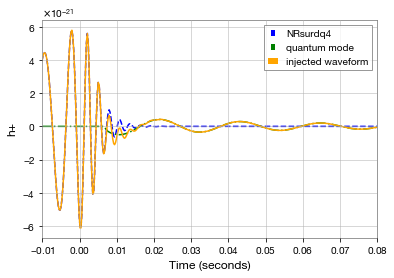

In [41]:
ifos = bilby.gw.detector.InterferometerList(['H1','L1'])
ifos.set_strain_data_from_power_spectral_densities(
    duration=duration, sampling_frequency=4096, start_time = injection_parameters['geocent_time']+t[0])
ifos.inject_signal(waveform_generator=injection_waveform,
                  parameters=injection_parameters)

In [56]:
prior = {}
prior['amplitude'] = bilby.core.prior.DeltaFunction(amplitude, r'$h_0$')
prior['tp'] = bilby.core.prior.DeltaFunction(0.001876, r'$t_{s}$')
#prior['tau'] = bilby.core.prior.DeltaFunction(0.0035034425359878212, r'$t_{s}$')
prior['tau'] = bilby.core.prior.LogUniform(1e-3, 1e-1, r'$\tau$', unit='$s$')
prior['freq'] = bilby.core.prior.Uniform(30, 100, r'frequency', unit='Hz')
prior['phase'] = bilby.core.prior.DeltaFunction(0)
prior['ra'] = bilby.core.prior.DeltaFunction(0)
prior['dec'] = bilby.core.prior.DeltaFunction(0)
prior['psi'] = bilby.core.prior.DeltaFunction(0)
prior['geocent_time'] = bilby.core.prior.DeltaFunction(0)

In [57]:
search_waveform = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=4096, 
    time_domain_source_model=Quantummodes_keys, start_time = injection_parameters['geocent_time']+t[0])

In [58]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=search_waveform)

In [59]:
result = bilby.run_sampler(
            likelihood=likelihood, priors=prior, sampler='dynesty', npoints=100, walks=5, 
            nact=3, outdir='/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurquantumfinal2', #change nref5,40
            label='Mass{}_dist{}_nref{}_Amp{}_CORRECT'.format(M, dist_mpc, n_ref, amplitude),
            resume=False, injection_parameters=dict(freq=84.799,
                                                    tau=0.0088))

22:02 bilby INFO    : Running for label 'Mass100_dist100_nref3_Amp2e-22_CORRECT', output will be saved to '/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurquantumfinal2'
22:02 bilby INFO    : Using LAL version Branch: None;Tag: lal-v6.22.0;Id: 38829b72bfb5f26391b9866d286dd77db7942dd1;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
22:02 bilby INFO    : Search parameters:
22:02 bilby INFO    :   tau = LogUniform(minimum=0.001, maximum=0.1, name='$\\tau$', latex_label='$\\tau$', unit='$s$', boundary=None)
22:02 bilby INFO    :   freq = Uniform(minimum=30, maximum=100, name='frequency', latex_label='frequency', unit='Hz', boundary=None)
22:02 bilby INFO    :   amplitude = 2e-22
22:02 bilby INFO    :   tp = 0.001876
22:02 bilby INFO    :   phase = 0
22:02 bilby INFO    :   ra = 0
22:02 bilby INFO    :   dec = 0
22:02 bilby INFO    :   psi = 0
22:02 bilby INFO    :   geocent_time = 0
/Users/zohaggard/anaconda2/envs/igwn-py37/li


0it [00:00, ?it/s]

22:03 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 100, 'first_update': None, 'walks': 5, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 60, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x131db1e50>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 3}
22:03 bilby INFO    : Checkpoint every n_check_point = 20000
22:03 bilby INFO    : Using dynesty version 1.0.1
22:03 bilby INFO    : Using the bilby-implemented rwalk sample metho


1it [00:04,  4.16s/it, bound:0 nc:1 ncall:101 eff:1.0% logz-ratio=196033.89+/-0.33 dlogz:inf>0.10]
4it [00:04,  2.92s/it, bound:0 nc:1 ncall:104 eff:3.8% logz-ratio=196042.84+/-0.30 dlogz:49.136>0.10]
7it [00:04,  2.06s/it, bound:0 nc:1 ncall:107 eff:6.5% logz-ratio=196048.15+/-0.31 dlogz:44.582>0.10]
10it [00:04,  1.45s/it, bound:0 nc:1 ncall:110 eff:9.1% logz-ratio=196057.62+/-0.32 dlogz:35.648>0.10]
13it [00:04,  1.03s/it, bound:0 nc:1 ncall:113 eff:11.5% logz-ratio=196060.27+/-0.27 dlogz:30.164>0.10]
16it [00:04,  1.36it/s, bound:0 nc:2 ncall:117 eff:13.7% logz-ratio=196061.67+/-0.25 dlogz:28.745>0.10]
19it [00:04,  1.89it/s, bound:0 nc:1 ncall:120 eff:15.8% logz-ratio=196063.61+/-0.26 dlogz:26.710>0.10]
22it [00:05,  2.62it/s, bound:0 nc:1 ncall:123 eff:17.9% logz-ratio=196067.84+/-0.32 dlogz:25.247>0.10]
25it [00:05,  3.52it/s, bound:0 nc:2 ncall:127 eff:19.7% logz-ratio=196070.00+/-0.27 dlogz:20.316>0.10]
28it [00:05,  4.60it/s, bound:0 nc:1 ncall:131 eff:21.4% logz-ratio=19607

248it [00:47,  1.08it/s, bound:0 nc:31 ncall:1215 eff:20.4% logz-ratio=196088.31+/-0.13 dlogz:0.397>0.10]
249it [00:48,  1.08it/s, bound:0 nc:25 ncall:1240 eff:20.1% logz-ratio=196088.31+/-0.13 dlogz:0.392>0.10]
250it [00:49,  1.27it/s, bound:0 nc:12 ncall:1252 eff:20.0% logz-ratio=196088.31+/-0.13 dlogz:0.388>0.10]
251it [00:49,  1.48it/s, bound:0 nc:11 ncall:1263 eff:19.9% logz-ratio=196088.32+/-0.13 dlogz:0.384>0.10]
252it [00:49,  1.73it/s, bound:0 nc:9 ncall:1272 eff:19.8% logz-ratio=196088.32+/-0.13 dlogz:0.380>0.10] 
254it [00:50,  2.07it/s, bound:0 nc:13 ncall:1286 eff:19.8% logz-ratio=196088.33+/-0.13 dlogz:0.371>0.10]
255it [00:50,  2.68it/s, bound:0 nc:3 ncall:1289 eff:19.8% logz-ratio=196088.33+/-0.13 dlogz:0.367>0.10] 
256it [00:51,  1.82it/s, bound:0 nc:25 ncall:1314 eff:19.5% logz-ratio=196088.33+/-0.13 dlogz:0.363>0.10]
257it [00:52,  1.37it/s, bound:0 nc:30 ncall:1344 eff:19.1% logz-ratio=196088.34+/-0.13 dlogz:0.359>0.10]
258it [00:53,  1.51it/s, bound:0 nc:13 ncall:1

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.



359it [02:18,  1.09it/s, bound:1 nc:15 ncall:3607 eff:10.0% logz-ratio=196088.53+/-0.12 dlogz:0.121>0.10]
360it [02:18,  1.28it/s, bound:1 nc:11 ncall:3618 eff:10.0% logz-ratio=196088.53+/-0.12 dlogz:0.120>0.10]
361it [02:19,  1.38it/s, bound:1 nc:15 ncall:3633 eff:9.9% logz-ratio=196088.53+/-0.12 dlogz:0.119>0.10] 
362it [02:20,  1.38it/s, bound:1 nc:18 ncall:3651 eff:9.9% logz-ratio=196088.53+/-0.12 dlogz:0.118>0.10]
363it [02:20,  1.52it/s, bound:1 nc:12 ncall:3663 eff:9.9% logz-ratio=196088.53+/-0.12 dlogz:0.116>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.



364it [02:21,  1.64it/s, bound:2 nc:12 ncall:3675 eff:9.9% logz-ratio=196088.53+/-0.12 dlogz:0.116>0.10]
365it [02:21,  1.59it/s, bound:2 nc:17 ncall:3692 eff:9.9% logz-ratio=196088.54+/-0.12 dlogz:0.115>0.10]
366it [02:22,  1.63it/s, bound:2 nc:14 ncall:3706 eff:9.9% logz-ratio=196088.54+/-0.12 dlogz:0.113>0.10]
367it [02:23,  1.58it/s, bound:2 nc:17 ncall:3723 eff:9.9% logz-ratio=196088.54+/-0.12 dlogz:0.112>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.



368it [02:23,  1.54it/s, bound:3 nc:17 ncall:3740 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.111>0.10]
369it [02:24,  1.45it/s, bound:3 nc:20 ncall:3760 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.110>0.10]
370it [02:25,  1.61it/s, bound:3 nc:11 ncall:3771 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.109>0.10]
371it [02:25,  1.72it/s, bound:3 nc:12 ncall:3783 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.108>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.



372it [02:26,  1.81it/s, bound:4 nc:11 ncall:3794 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.107>0.10]
373it [02:26,  1.75it/s, bound:4 nc:15 ncall:3809 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.105>0.10]
374it [02:27,  1.83it/s, bound:4 nc:10 ncall:3819 eff:9.8% logz-ratio=196088.54+/-0.12 dlogz:0.104>0.10]
375it [02:27,  1.73it/s, bound:4 nc:14 ncall:3833 eff:9.8% logz-ratio=196088.55+/-0.12 dlogz:0.103>0.10]
376it [02:28,  1.52it/s, bound:4 nc:19 ncall:3852 eff:9.8% logz-ratio=196088.55+/-0.12 dlogz:0.102>0.10]

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.



377it [02:29,  1.42it/s, bound:5 nc:18 ncall:3870 eff:9.7% logz-ratio=196088.55+/-0.12 dlogz:0.101>0.10]
378it [02:30,  1.45it/s, bound:5 nc:15 ncall:3885 eff:9.7% logz-ratio=196088.55+/-0.12 dlogz:0.100>0.10]

22:05 bilby INFO    : Writing checkpoint file /Users/zohaggard/Desktop/LIGOSURF/add_quantummode/NRsurquantumfinal2/Mass100_dist100_nref3_Amp2e-22_CORRECT_resume.pickle



378it [02:30,  2.51it/s, bound:5 nc:1 ncall:3885 eff:12.3% logz-ratio=196088.64+/-0.11 dlogz:0.001>0.10]

22:05 bilby INFO    : Sampling time: 0:02:26.022587
22:05 bilby INFO    : Summary of results:
nsamples: 478
log_noise_evidence: -208024.559
log_evidence: -11935.920 +/-  0.111
log_bayes_factor: 196088.639 +/-  0.111



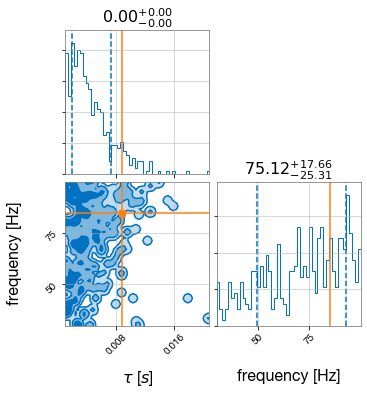

In [60]:
result.plot_corner()